In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_treated = pd.read_csv('data/df_treated.csv').set_index('date')
df_treated.index = pd.to_datetime(df_treated.index)

In [3]:
numeric_col = ['Building0', 'Building1', 'Building3', 'Building4', 'Building5',
                   'Building6', 'Solar0', 'Solar1', 'Solar2', 'Solar3', 'Solar4', 'Solar5',
                   'temperature', 'dewpoint_temperature', 'wind_speed',
                   'mean_sea_level_pressure', 'relative_humidity_01',
                   'surface_solar_radiation', 'surface_thermal_radiation',
                   'total_cloud_cover']
df_treated[numeric_col] = df_treated[numeric_col].apply(pd.to_numeric)
df_numerics = df_treated[numeric_col]

categorical_col = ['COVID', 'Break', 'Semester', 'Exams', 'Monash_occupancy',
               'month', 'day', 'hour']
df_treated[categorical_col] = df_treated[categorical_col].astype('category')
df_categorical = df_treated[categorical_col]

In [4]:
df_hour = df_treated.resample('H').last()

# Buildings

## Building0

In [5]:
# Selección train-test
print(9696 * 0.10) # 1 mes y 10 dias aprox
df_hour['Building0'].iloc[-969:]

969.6


date
2020-09-21 15:00:00    154.6
2020-09-21 16:00:00    155.0
2020-09-21 17:00:00    158.0
2020-09-21 18:00:00    150.9
2020-09-21 19:00:00    154.0
                       ...  
2020-10-31 19:00:00    141.4
2020-10-31 20:00:00    138.5
2020-10-31 21:00:00    123.0
2020-10-31 22:00:00    105.0
2020-10-31 23:00:00     77.6
Freq: H, Name: Building0, Length: 969, dtype: float64

In [6]:
y_train_B0 = df_hour['Building0'][:'2020-09-21 14:00:00']
y_test_B0 = df_hour['Building0']['2020-09-21 15:00:00':]

print(y_train_B0.shape, y_test_B0.shape)
y_train_B0.shape[0] + y_test_B0.shape[0]

(8727,) (969,)


9696

### Naive seasonal B0

In [7]:
fh_naive = np.arange(1, 970)
forecaster = NaiveForecaster(strategy='last', sp=24)

In [8]:
forecaster.fit(y_train_B0)

NaiveForecaster(sp=24)

In [9]:
y_pred_B0 = forecaster.predict(fh_naive)

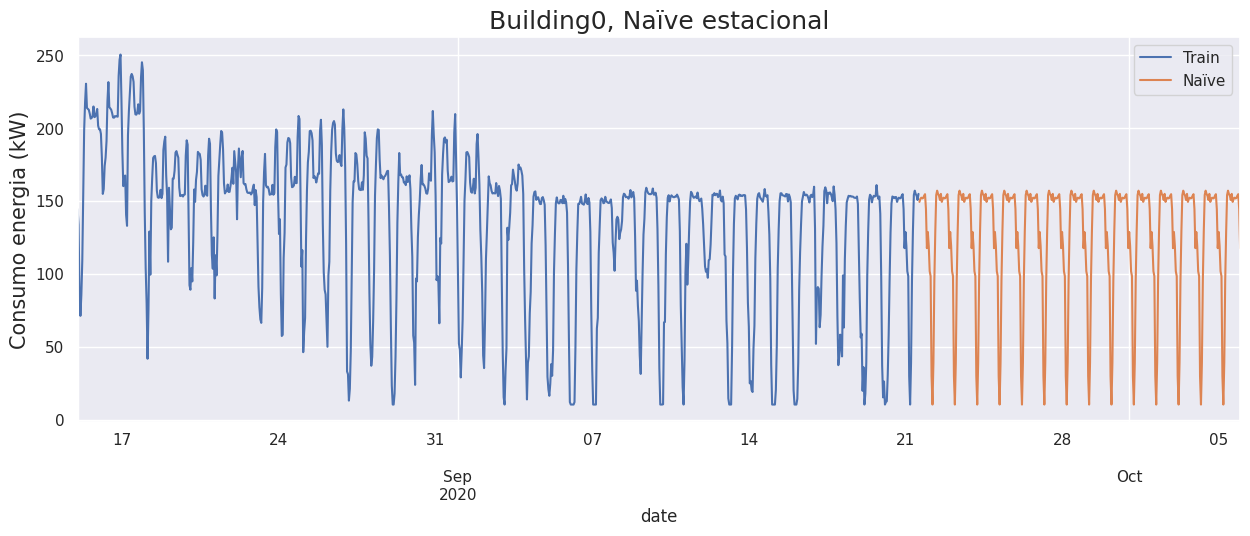

In [10]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_B0['2020-08-15':].plot(linestyle='-')), (y_pred_B0[:'2020-10-05'].plot(linestyle='-'))
plt.title('Building0, Naïve estacional', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15)
plt.legend(labels=["Train","Naïve"])
plt.savefig('images/B0_Naive.png')
plt.show()

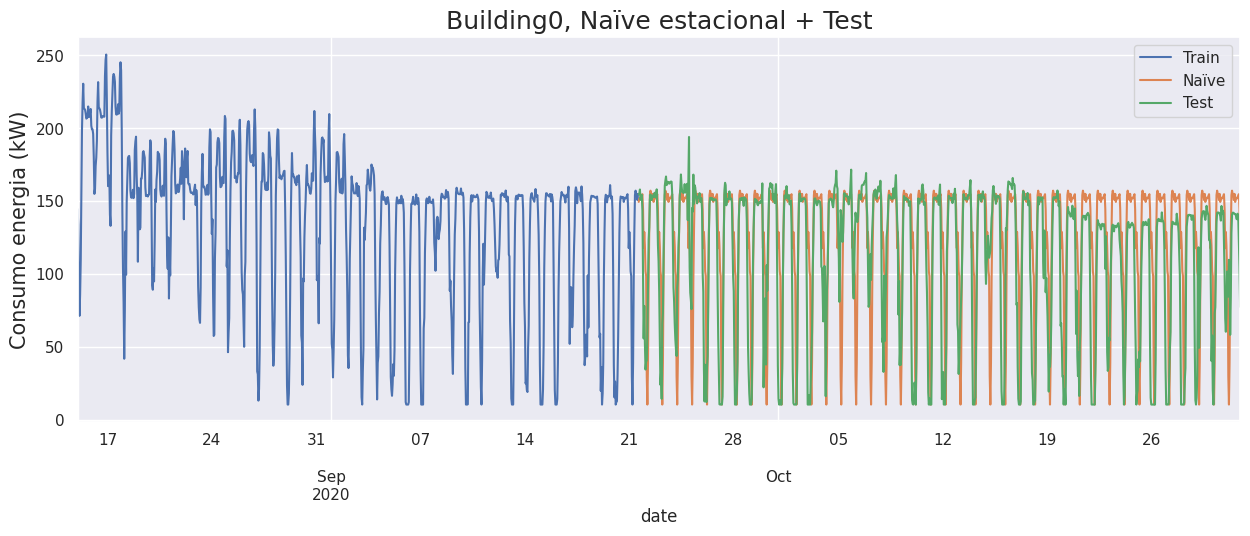

In [11]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_B0['2020-08-15':].plot(linestyle='-')), \
     (y_pred_B0.plot(linestyle='-')), \
     (y_test_B0.plot(linestyle='-'))
plt.title('Building0, Naïve estacional + Test', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15) 
plt.legend(labels=["Train", "Naïve", "Test"])
plt.savefig('images/B0_Naive_test.png')
plt.show()

In [12]:
# Error scores: MAE MAPE MSE R2
mae = MeanAbsoluteError()
mse = MeanSquaredError()
Naive_mae_B0 = mae(y_test_B0, y_pred_B0)
Naive_mse_B0 = mse(y_test_B0, y_pred_B0)
Naive_r2_B0 = r2_score(y_test_B0, y_pred_B0)
Naive_mape_B0 = mean_absolute_percentage_error(y_test_B0, y_pred_B0)

print(f"MAE: {Naive_mae_B0:.4} \
        MSE: {Naive_mse_B0:.4} \
        R2: {Naive_r2_B0:.4} \
        MAPE: {Naive_mape_B0:.4}")

MAE: 25.97         MSE: 1.646e+03         R2: 0.3621         MAPE: 0.9214


### ETS B0

In [13]:
fh = np.arange(1, 970)
autoETS_model = AutoETS(auto=True, sp=24, n_jobs=-1)

In [14]:
autoETS_model.fit(y_train_B0)

AutoETS(auto=True, n_jobs=-1, sp=24)

In [15]:
#  Auto ETS Model Summary
print(autoETS_model.summary())

                                 ETS Results                                  
Dep. Variable:              Building0   No. Observations:                 8727
Model:                      ETS(AAdA)   Log Likelihood              -39684.742
Date:                Thu, 08 Sep 2022   AIC                          79431.484
Time:                        21:27:15   BIC                          79650.784
Sample:                    09-24-2019   HQIC                         79506.221
                         - 09-21-2020   Scale                          521.562
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.7705      0.011     70.373      0.000       0.749       0.792
smoothing_trend      7.705e-05      0.000      0.234      0.815      -0.001       0.001
smoothing_season

In [16]:
#  Auto ETS Forecasting
ETS_pred_B0 = autoETS_model.predict(fh)

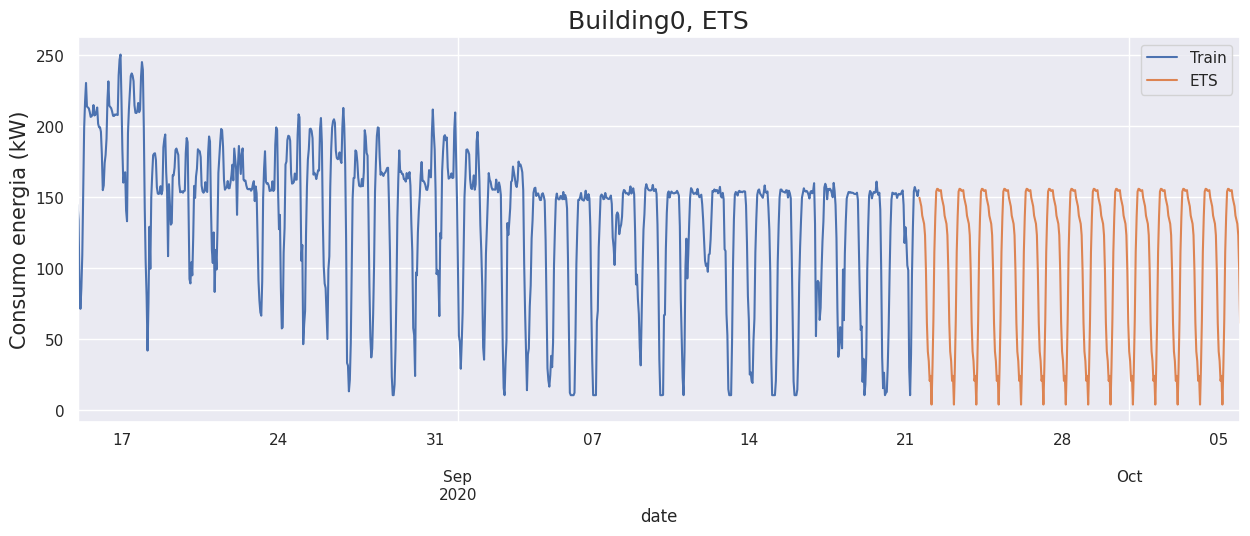

In [17]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_B0['2020-08-15':].plot(linestyle='-')), (ETS_pred_B0[:'2020-10-05'].plot(linestyle='-'))
plt.title('Building0, ETS', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15)
plt.legend(labels=["Train","ETS"])
plt.savefig('images/B0_ETS.png')
plt.show()

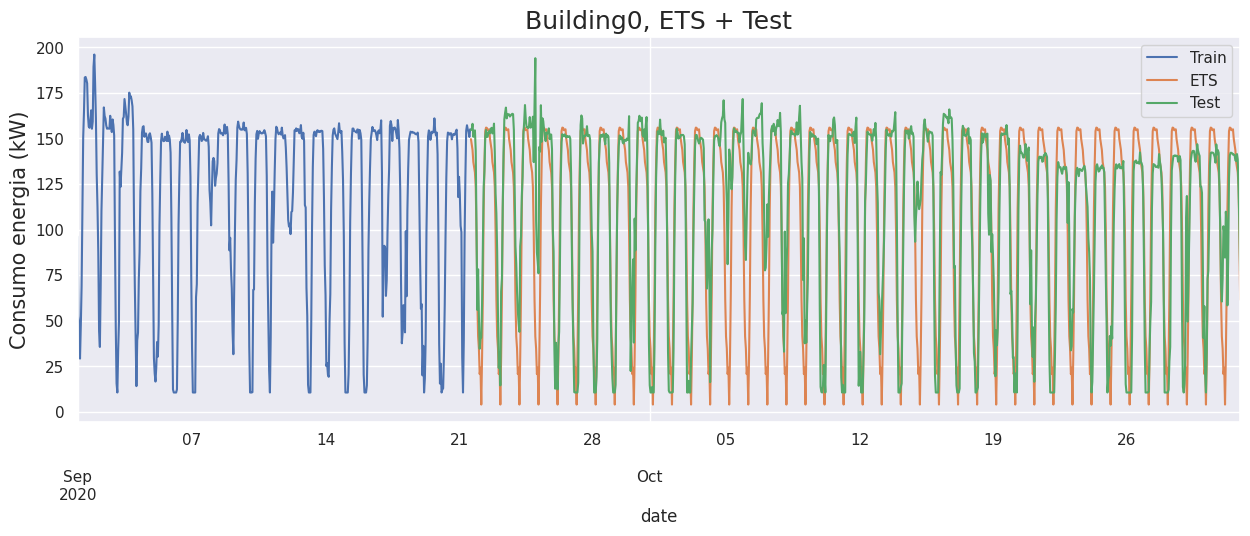

In [18]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_B0['2020-09-01':].plot(linestyle='-')), \
     (ETS_pred_B0.plot(linestyle='-')), \
     (y_test_B0.plot(linestyle='-'))
plt.title('Building0, ETS + Test', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15) 
plt.legend(labels=["Train", "ETS", "Test"])
plt.savefig('images/B0_ETS_test.png')
plt.show()

In [19]:
# Error scores: MAE MAPE MSE R2
mae = MeanAbsoluteError()
mse = MeanSquaredError()
ETS_mae_B0 = mae(y_test_B0, ETS_pred_B0)
ETS_mse_B0 = mse(y_test_B0, ETS_pred_B0)
ETS_r2_B0 = r2_score(y_test_B0, ETS_pred_B0)
ETS_mape_B0 = mean_absolute_percentage_error(y_test_B0, ETS_pred_B0)

print(f"MAE: {ETS_mae_B0:.4} \
        MSE: {ETS_mse_B0:.4} \
        R2: {ETS_r2_B0:.4} \
        MAPE: {ETS_mape_B0:.4}")

MAE: 19.22         MSE: 807.7         R2: 0.6869         MAPE: 0.3601


## Building3

In [20]:
y_train_B3 = df_hour['Building3'][:'2020-09-21 14:00:00']
y_test_B3 = df_hour['Building3']['2020-09-21 15:00:00':]

print(y_train_B3.shape, y_test_B3.shape)
y_train_B3.shape[0] + y_test_B3.shape[0]

(8727,) (969,)


9696

### Naive estacional B3

In [21]:
fh_naive = np.arange(1, 970)
forecaster = NaiveForecaster(strategy='last', sp=24)

In [22]:
forecaster.fit(y_train_B3)

NaiveForecaster(sp=24)

In [23]:
y_pred_B3 = forecaster.predict(fh_naive)

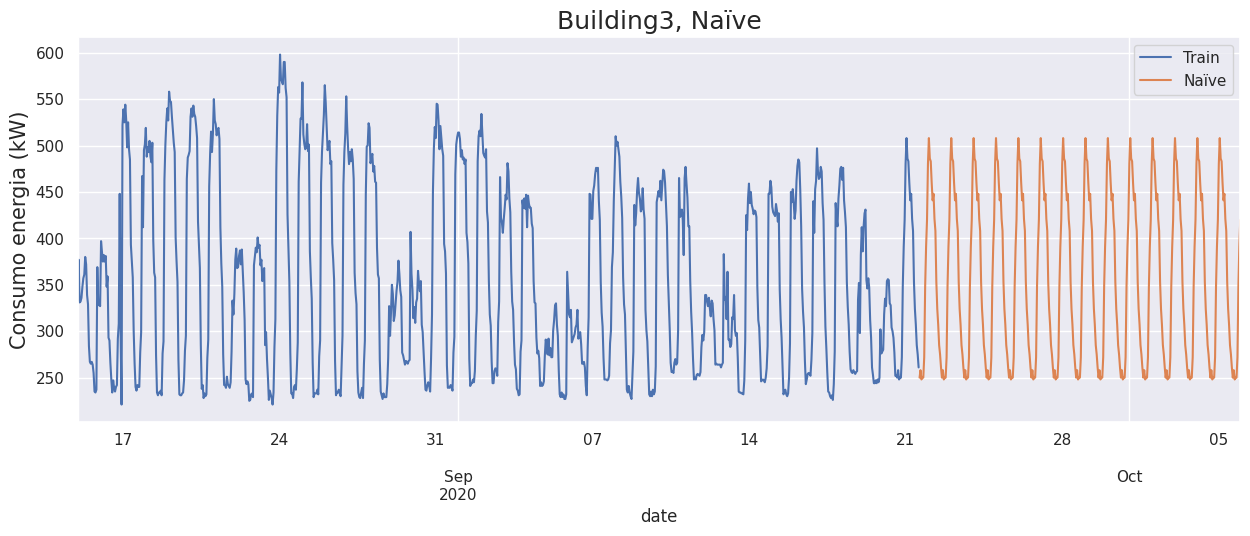

In [24]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_B3['2020-08-15':].plot(linestyle='-')), (y_pred_B3[:'2020-10-05'].plot(linestyle='-'))
plt.title('Building3, Naïve', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15)
plt.legend(labels=["Train","Naïve"])
plt.savefig('images/B3_Naive.png')
plt.show()

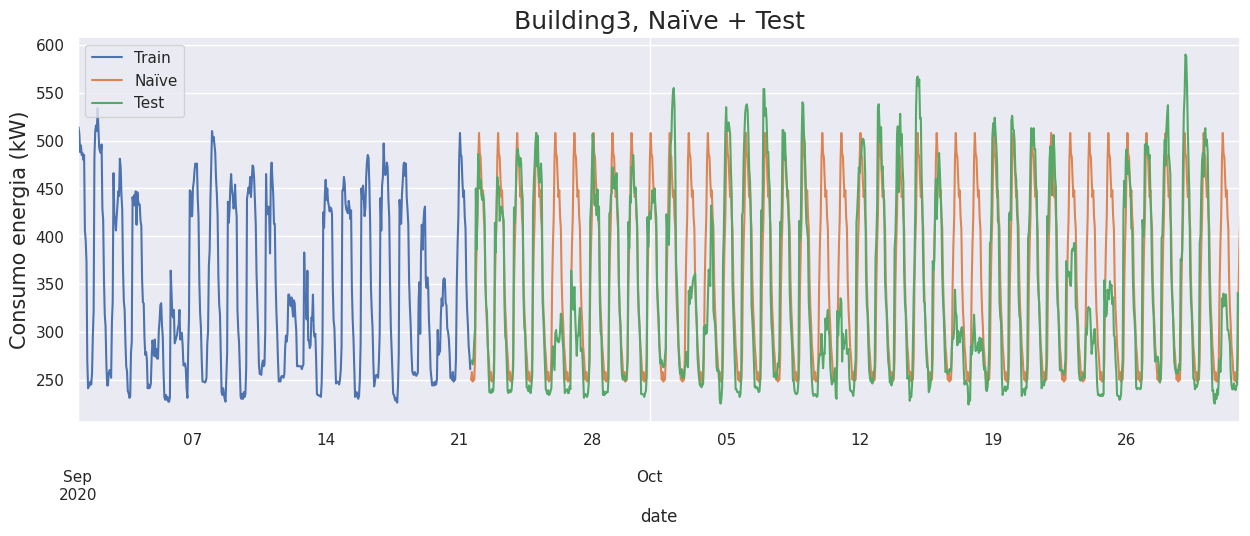

In [25]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_B3['2020-09-01':].plot(linestyle='-')), \
     (y_pred_B3.plot(linestyle='-')), \
     (y_test_B3.plot(linestyle='-'))
plt.title('Building3, Naïve + Test', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15) 
plt.legend(labels=["Train", "Naïve", "Test"])
plt.savefig('images/B3_Naive_test.png')
plt.show()

In [26]:
# Error scores: MAE MAPE MSE R2
mae = MeanAbsoluteError()
mse = MeanSquaredError()
Naive_mae_B3 = mae(y_test_B3, y_pred_B3)
Naive_mse_B3 = mse(y_test_B3, y_pred_B3)
Naive_r2_B3 = r2_score(y_test_B3, y_pred_B3)
Naive_mape_B3 = mean_absolute_percentage_error(y_test_B3, y_pred_B3)

print(f"MAE: {Naive_mae_B3:.4} \
        MSE: {Naive_mse_B3:.4} \
        R2: {Naive_r2_B3:.4} \
        MAPE: {Naive_mape_B3:.4}")

MAE: 43.7         MSE: 4.129e+03         R2: 0.56         MAPE: 0.1322


### ETS B3

In [27]:
fh = np.arange(1, 970)
autoETS_model = AutoETS(auto=True, sp=24, n_jobs=-1)

In [28]:
autoETS_model.fit(y_train_B3)

/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AutoETS(auto=True, n_jobs=-1, sp=24)

In [29]:
#  Auto ETS Forecasting
ETS_pred_B3 = autoETS_model.predict(fh)

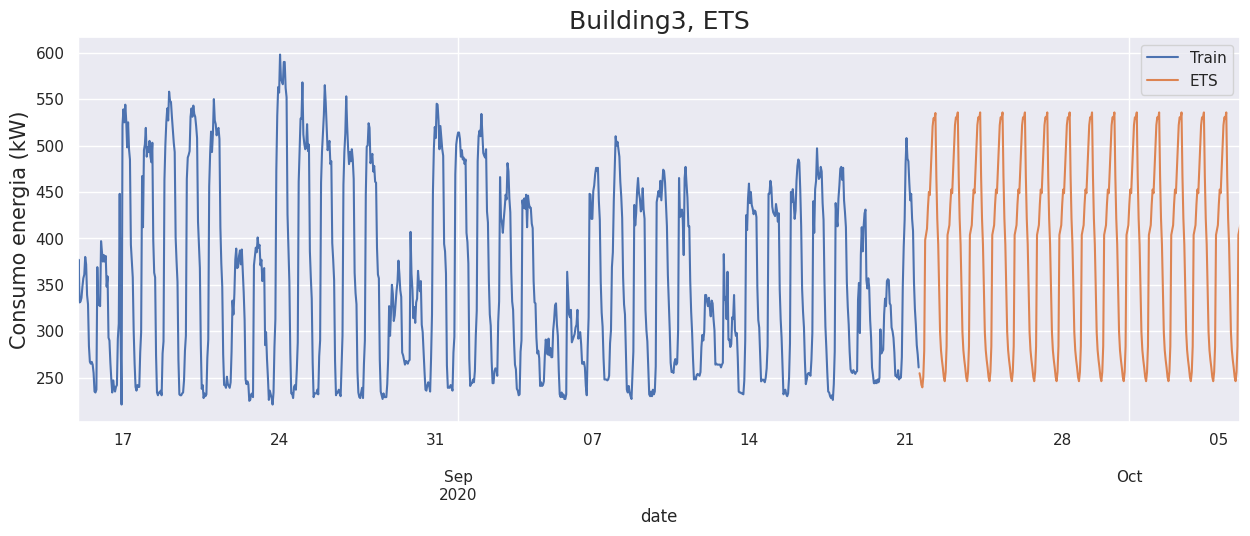

In [30]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_B3['2020-08-15':].plot(linestyle='-')), (ETS_pred_B3[:'2020-10-05'].plot(linestyle='-'))
plt.title('Building3, ETS', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15)
plt.legend(labels=["Train","ETS"])
plt.savefig('images/B3_ETS.png')
plt.show()

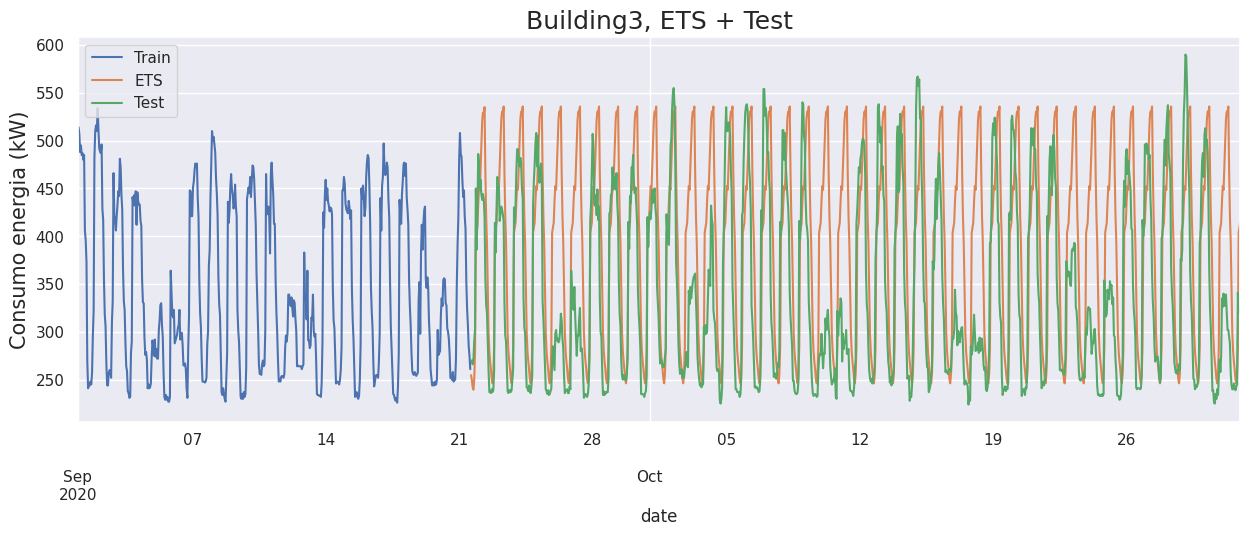

In [31]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_B3['2020-09-01':].plot(linestyle='-')), \
     (ETS_pred_B3.plot(linestyle='-')), \
     (y_test_B3.plot(linestyle='-'))
plt.title('Building3, ETS + Test', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15) 
plt.legend(labels=["Train", "ETS", "Test"])
plt.savefig('images/B3_ETS_test.png')
plt.show()

In [32]:
# Error scores: MAE MAPE MSE R2
mae = MeanAbsoluteError()
mse = MeanSquaredError()
ETS_mae_B3 = mae(y_test_B3, ETS_pred_B3)
ETS_mse_B3 = mse(y_test_B3, ETS_pred_B3)
ETS_r2_B3 = r2_score(y_test_B3, ETS_pred_B3)
ETS_mape_B3 = mean_absolute_percentage_error(y_test_B3, ETS_pred_B3)

print(f"MAE: {ETS_mae_B3:.4} \
        MSE: {ETS_mse_B3:.4} \
        R2: {ETS_r2_B3:.4} \
        MAPE: {ETS_mape_B3:.4}")

MAE: 72.21         MSE: 8.805e+03         R2: 0.06186         MAPE: 0.223


# Solar panels

## Solar 1

In [33]:
# Selección train-test
print(3931 * 0.10) # 1 mes y 10 dias aprox
df_hour['Solar1'].iloc[-393:]

393.1


date
2020-10-15 15:00:00    0.00
2020-10-15 16:00:00    0.00
2020-10-15 17:00:00    0.00
2020-10-15 18:00:00    0.00
2020-10-15 19:00:00    0.33
                       ... 
2020-10-31 19:00:00    0.29
2020-10-31 20:00:00    1.07
2020-10-31 21:00:00    2.15
2020-10-31 22:00:00    4.96
2020-10-31 23:00:00    7.34
Freq: H, Name: Solar1, Length: 393, dtype: float64

In [34]:
y_train_S1 = df_hour['Solar1']['2020-05-21 05:00:00':'2020-10-15 14:00:00']
y_test_S1 = df_hour['Solar1']['2020-10-15 15:00:00':]

print(y_train_S1.shape, y_test_S1.shape)
y_train_S1.shape[0] + y_test_S1.shape[0]

(3538,) (393,)


3931

### Naive estacional S1

In [35]:
fh_naive = np.arange(1, 394)
forecaster = NaiveForecaster(strategy='last', sp=24*2)

In [36]:
forecaster.fit(y_train_S1)

NaiveForecaster(sp=48)

In [37]:
y_pred_S1 = forecaster.predict(fh_naive)

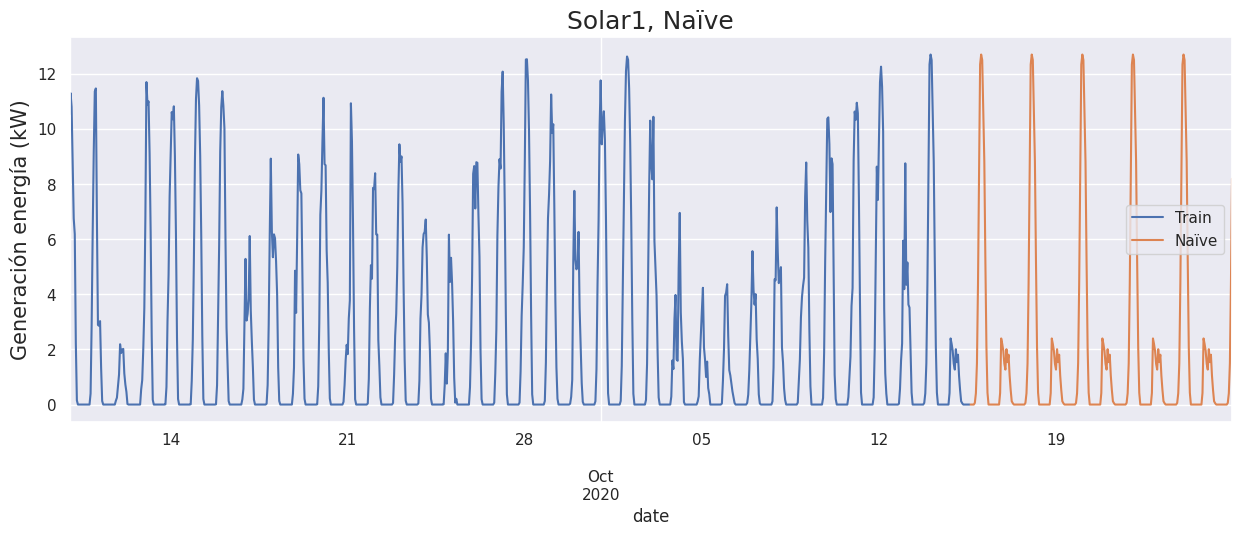

In [38]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_S1['2020-09-10':].plot(linestyle='-')), (y_pred_S1[:'2020-10-25'].plot(linestyle='-'))
plt.title('Solar1, Naïve', fontsize = 18) 
plt.ylabel('Generación energía (kW)', fontsize = 15)
plt.legend(labels=["Train","Naïve"])
plt.savefig('images/S1_Naive.png')
plt.show()

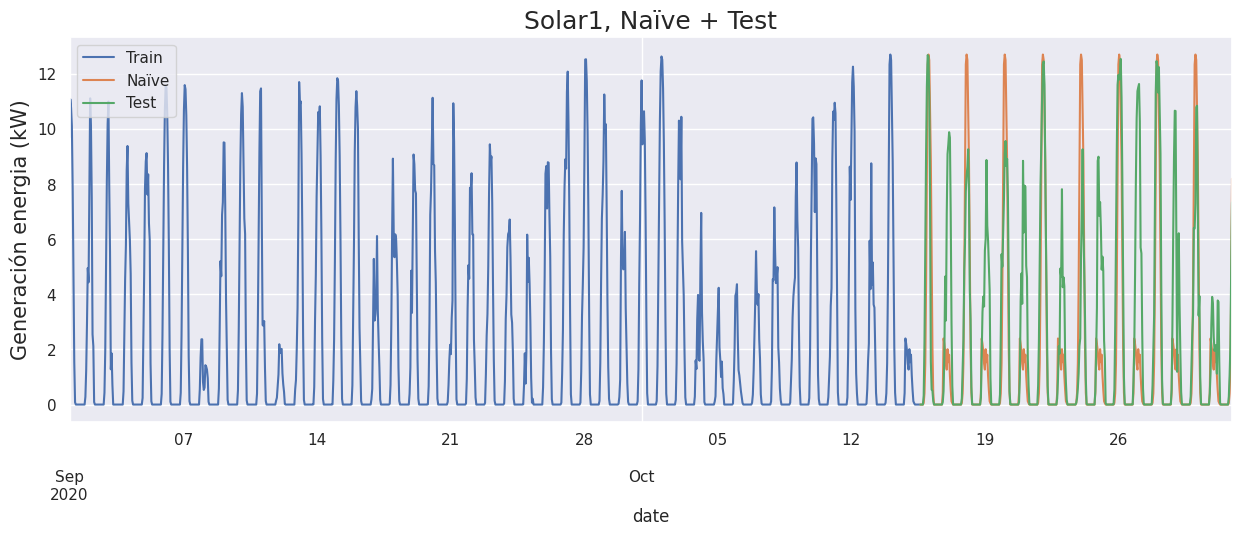

In [39]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_S1['2020-09-01':].plot(linestyle='-')), \
     (y_pred_S1.plot(linestyle='-')), \
     (y_test_S1.plot(linestyle='-'))
plt.title('Solar1, Naïve + Test', fontsize = 18) 
plt.ylabel('Generación energia (kW)', fontsize = 15) 
plt.legend(labels=["Train", "Naïve", "Test"])
plt.savefig('images/S1_Naive_test.png')
plt.show()

In [40]:
# Error scores: MAE MAPE MSE R2
mae = MeanAbsoluteError()
mse = MeanSquaredError()
Naive_mae_S1 = mae(y_test_S1, y_pred_S1)
Naive_mse_S1 = mse(y_test_S1, y_pred_S1)
Naive_r2_S1 = r2_score(y_test_S1, y_pred_S1)
Naive_mape_S1 = mean_absolute_percentage_error(y_test_S1, y_pred_S1)

print(f"MAE: {Naive_mae_S1:.4} \
        MSE: {Naive_mse_S1:.4} \
        R2: {Naive_r2_S1:.4} \
        MAPE: {Naive_mape_S1:.4}")

MAE: 1.425         MSE: 7.012         R2: 0.5015         MAPE: 0.434


### ETS S1

In [41]:
fh = np.arange(1, 394)
autoETS_model = AutoETS(auto=True, sp=24*2, n_jobs=-1)

In [42]:
autoETS_model.fit(y_train_S1)

/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AutoETS(auto=True, n_jobs=-1, sp=48)

In [43]:
#  Auto ETS Forecasting
ETS_pred_S1 = autoETS_model.predict(fh)

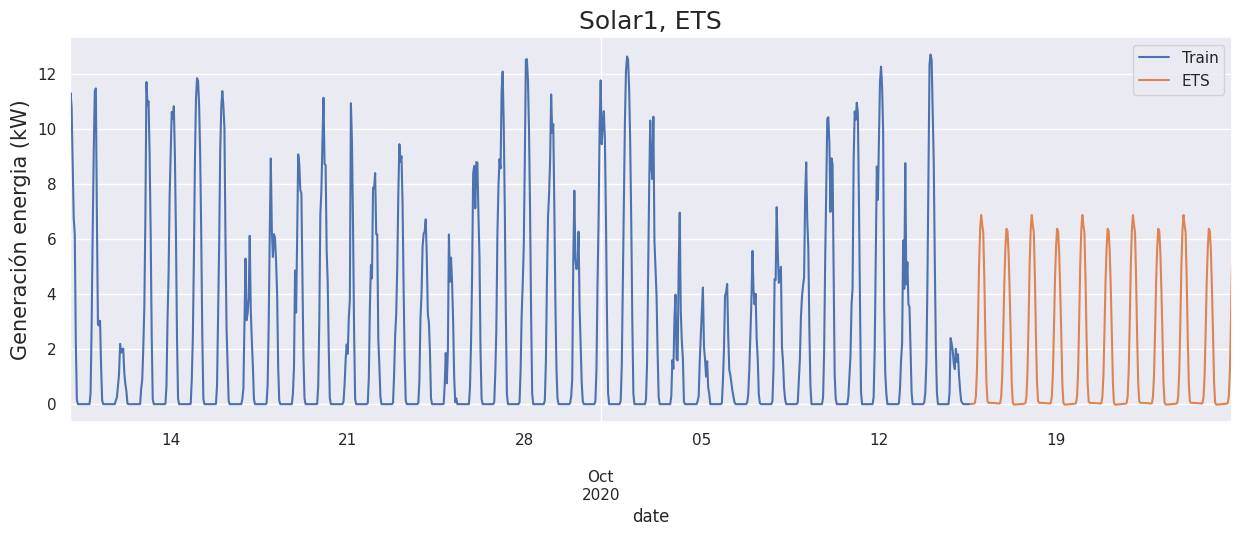

In [44]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_S1['2020-09-10':].plot(linestyle='-')), (ETS_pred_S1[:'2020-10-25'].plot(linestyle='-'))
plt.title('Solar1, ETS', fontsize = 18) 
plt.ylabel('Generación energia (kW)', fontsize = 15)
plt.legend(labels=["Train","ETS"])
plt.savefig('images/S1_ETS.png')
plt.show()

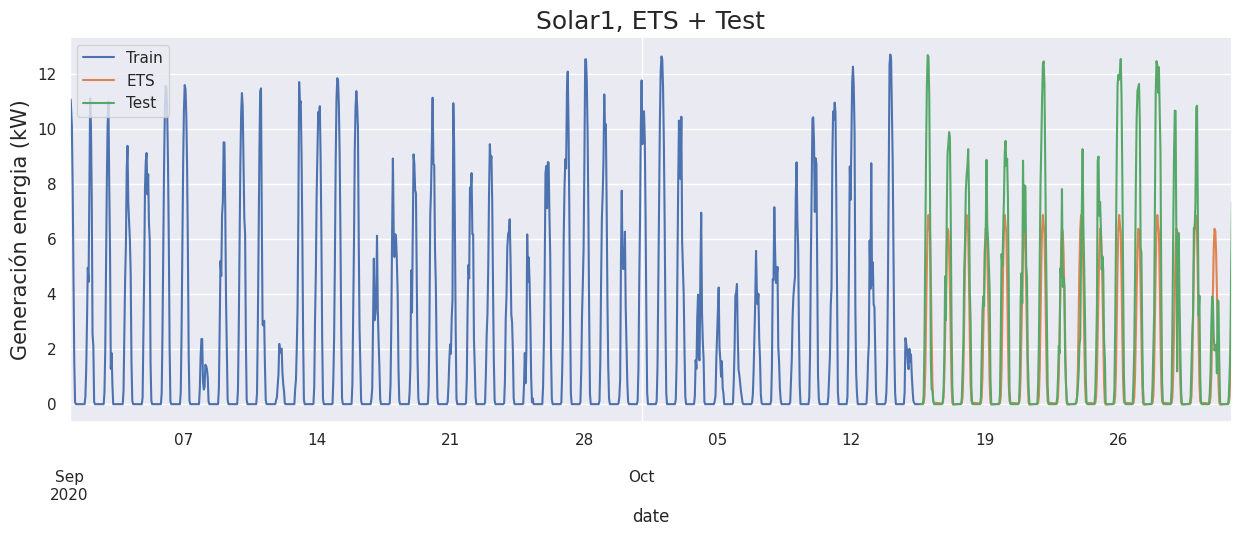

In [45]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_S1['2020-09-01':].plot(linestyle='-')), \
     (ETS_pred_S1.plot(linestyle='-')), \
     (y_test_S1.plot(linestyle='-'))
plt.title('Solar1, ETS + Test', fontsize = 18) 
plt.ylabel('Generación energia (kW)', fontsize = 15) 
plt.legend(labels=["Train", "ETS", "Test"])
plt.savefig('images/S1_ETS_test.png')
plt.show()

In [46]:
# Error scores: MAE MAPE MSE R2
mae = MeanAbsoluteError()
mse = MeanSquaredError()
ETS_mae_S1 = mae(y_test_S1, ETS_pred_S1)
ETS_mse_S1 = mse(y_test_S1, ETS_pred_S1)
ETS_r2_S1 = r2_score(y_test_S1, ETS_pred_S1)
ETS_mape_S1 = mean_absolute_percentage_error(y_test_S1, ETS_pred_S1)

print(f"MAE: {ETS_mae_S1:.4} \
        MSE: {ETS_mse_S1:.4} \
        R2: {ETS_r2_S1:.4} \
        MAPE: {ETS_mape_S1:.4}")

MAE: 1.33         MSE: 5.243         R2: 0.6273         MAPE: 4.154e+13


## Solar3

In [47]:
y_train_S3 = df_hour['Solar3']['2020-05-21 05:00:00':'2020-10-15 14:00:00']
y_test_S3 = df_hour['Solar3']['2020-10-15 15:00:00':]

print(y_train_S3.shape, y_test_S3.shape)
y_train_S3.shape[0] + y_test_S3.shape[0]

(3538,) (393,)


3931

### Naive estacional B3

In [48]:
fh_naive = np.arange(1, 394)
forecaster = NaiveForecaster(strategy='last', sp=24*2)

In [49]:
forecaster.fit(y_train_S3)

NaiveForecaster(sp=48)

In [50]:
y_pred_S3 = forecaster.predict(fh_naive)

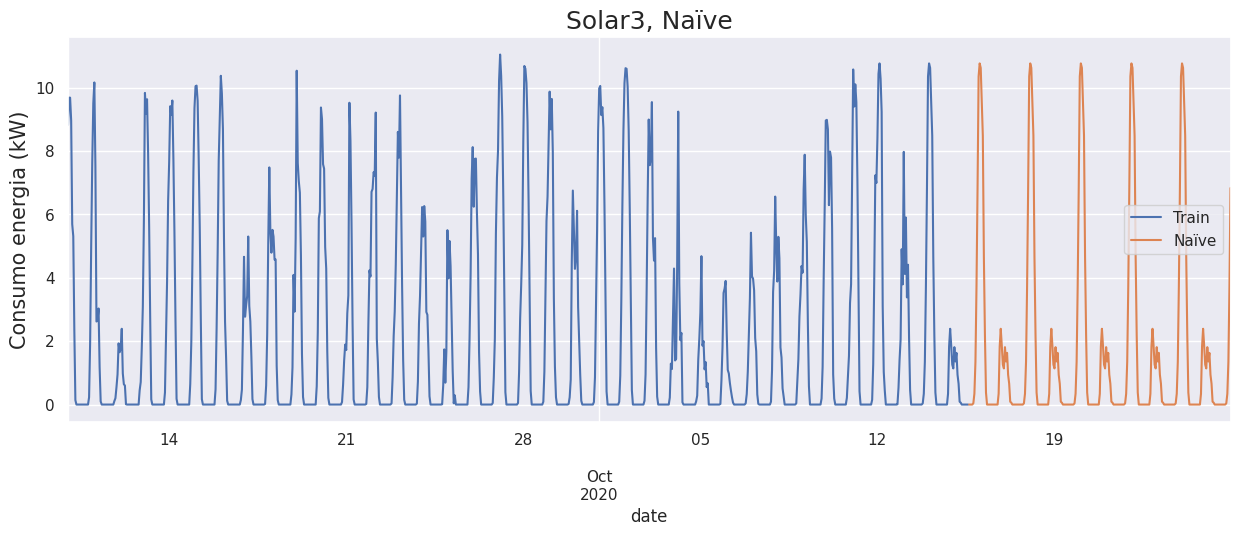

In [51]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_S3['2020-09-10':].plot(linestyle='-')), (y_pred_S3[:'2020-10-25'].plot(linestyle='-'))
plt.title('Solar3, Naïve', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15)
plt.legend(labels=["Train","Naïve"])
plt.savefig('images/S3_Naive.png')
plt.show()

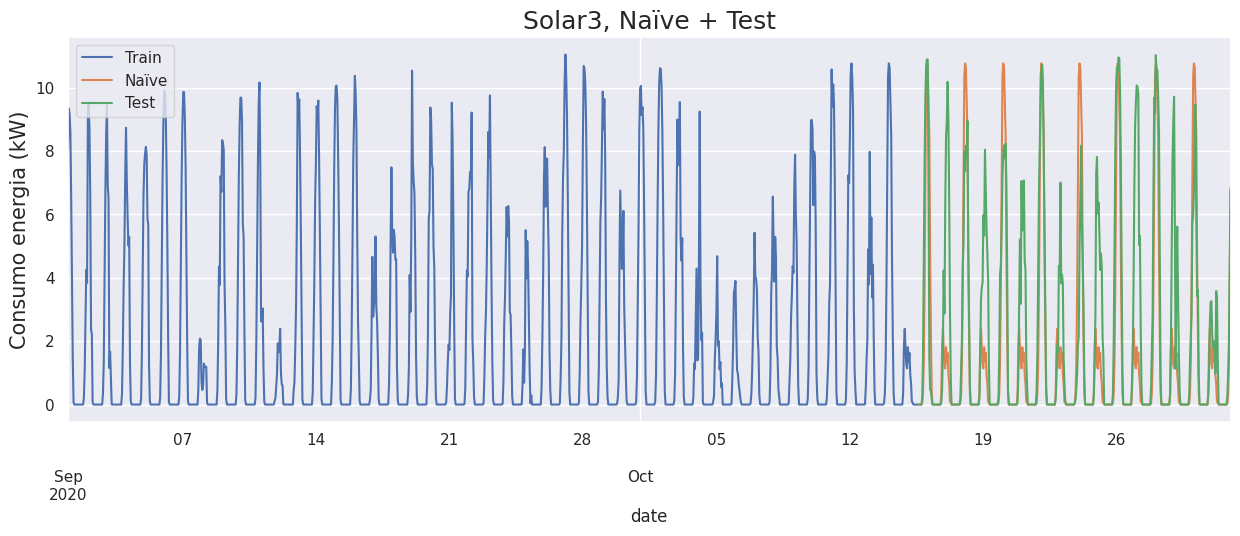

In [52]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_S3['2020-09-01':].plot(linestyle='-')), \
     (y_pred_S3.plot(linestyle='-')), \
     (y_test_S3.plot(linestyle='-'))
plt.title('Solar3, Naïve + Test', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15) 
plt.legend(labels=["Train", "Naïve", "Test"])
plt.savefig('images/S3_Naive_test.png')
plt.show()

In [53]:
# Error scores: MAE MAPE MSE R2
mae = MeanAbsoluteError()
mse = MeanSquaredError()
Naive_mae_S3 = mae(y_test_S3, y_pred_S3)
Naive_mse_S3 = mse(y_test_S3, y_pred_S3)
Naive_r2_S3 = r2_score(y_test_S3, y_pred_S3)
Naive_mape_S3 = mean_absolute_percentage_error(y_test_S3, y_pred_S3)

print(f"MAE: {Naive_mae_S3:.4} \
        MSE: {Naive_mse_S3:.4} \
        R2: {Naive_r2_S3:.4} \
        MAPE: {Naive_mape_S3:.4}")

MAE: 1.216         MSE: 5.304         R2: 0.5221         MAPE: 0.4053


### ETS B3

In [54]:
fh = np.arange(1, 394)
autoETS_model = AutoETS(auto=True, sp=24*2, n_jobs=-1)

In [55]:
autoETS_model.fit(y_train_S3)

/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AutoETS(auto=True, n_jobs=-1, sp=48)

In [56]:
#  Auto ETS Forecasting
ETS_pred_S3 = autoETS_model.predict(fh)

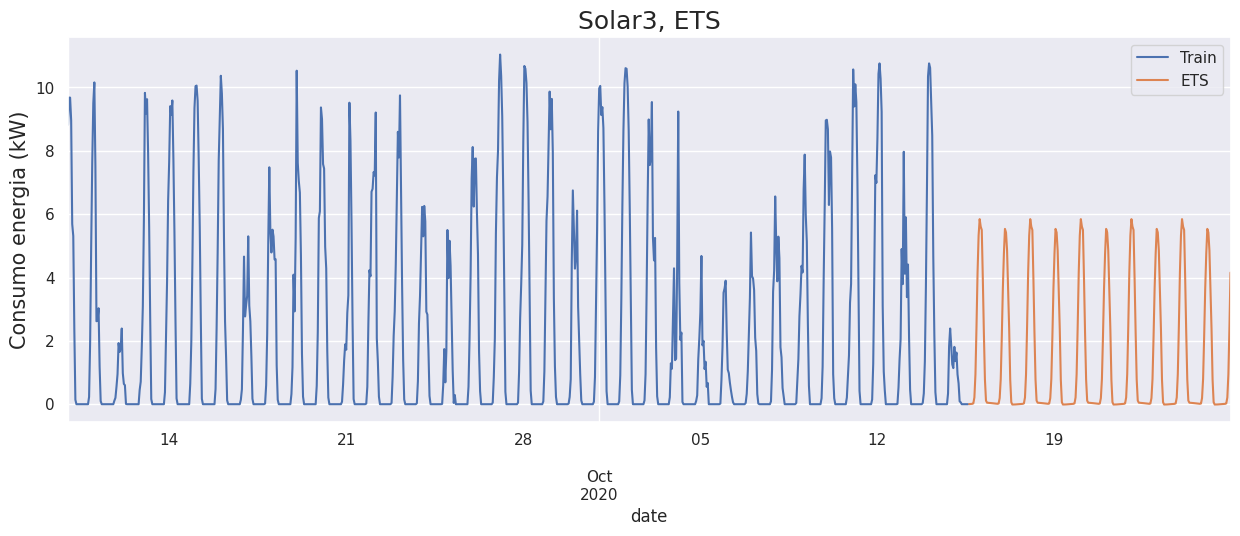

In [57]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_S3['2020-09-10':].plot(linestyle='-')), (ETS_pred_S3[:'2020-10-25'].plot(linestyle='-'))
plt.title('Solar3, ETS', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15)
plt.legend(labels=["Train","ETS"])
plt.savefig('images/S3_ETS.png')
plt.show()

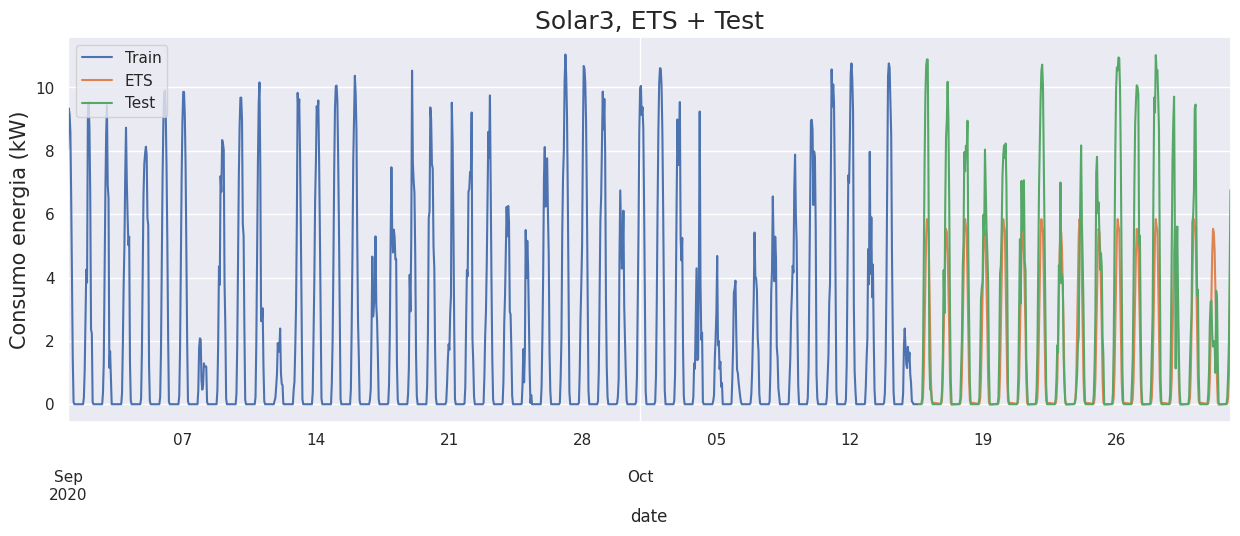

In [58]:
sns.set(rc={'figure.figsize':(15, 5)})
ax = (y_train_S3['2020-09-01':].plot(linestyle='-')), \
     (ETS_pred_S3.plot(linestyle='-')), \
     (y_test_S3.plot(linestyle='-'))
plt.title('Solar3, ETS + Test', fontsize = 18) 
plt.ylabel('Consumo energia (kW)', fontsize = 15) 
plt.legend(labels=["Train", "ETS", "Test"])
plt.savefig('images/S3_ETS_test.png')
plt.show()

In [59]:
# Error scores: MAE MAPE MSE R2
mae = MeanAbsoluteError()
mse = MeanSquaredError()
ETS_mae_S3 = mae(y_test_S3, ETS_pred_S3)
ETS_mse_S3 = mse(y_test_S3, ETS_pred_S3)
ETS_r2_S3 = r2_score(y_test_S3, ETS_pred_S3)
ETS_mape_S3 = mean_absolute_percentage_error(y_test_S3, ETS_pred_S3)

print(f"MAE: {ETS_mae_S3:.4} \
        MSE: {ETS_mse_S3:.4} \
        R2: {ETS_r2_S3:.4} \
        MAPE: {ETS_mape_S3:.4}")

MAE: 1.213         MSE: 4.296         R2: 0.613         MAPE: 3.532e+13
